#Important Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import torch.nn.functional as F


#Converting ZIP file for computation

In [2]:
import zipfile
import os

def unzip_file(zip_file_path, extract_to):
    """
    Unzips a zip file to the specified directory.

    Args:
        zip_file_path (str): Path to the zip file.
        extract_to (str): Directory to extract the contents to.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed successfully!")

# Example usage
zip_file_path = "/content/Project_dataset/dataset.zip"  # Path to your zip file
extract_to = "/content/Project_dataset"  # Directory where you want to extract the files
unzip_file(zip_file_path, extract_to)

Extraction completed successfully!


# Checking GPU

In [3]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available()else"cpu")

#CNN Neural Network Architecture

In [4]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.mean(x, dim=[2, 3])  # Global average pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Creating Subset for Model Training

In [5]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_images_per_class=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.num_images_per_class = num_images_per_class
        self.classes = os.listdir(root_dir)

    def __len__(self):
        return len(self.classes) * self.num_images_per_class

    def __getitem__(self, idx):
        class_idx = idx // self.num_images_per_class
        class_folder = self.classes[class_idx]
        class_path = os.path.join(self.root_dir, class_folder)
        files = os.listdir(class_path)
        file_idx = idx % len(files)
        img_name = files[file_idx]
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx


#Creating Subset for Test Dataset

In [6]:
# Define a custom dataset class for test data
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

#Preprossing Data

In [7]:
# Define transforms for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transforms for test data
test_transform = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Spliting Data for Training, Validation and Test

In [8]:
# Split Train dataset into training and validation sets
train_data = datasets.ImageFolder(root='/content/Project_dataset/Train', transform=train_transform)
val_size = int(0.2 * len(train_data))
train_data, val_data = torch.utils.data.random_split(train_data, [len(train_data) - val_size, val_size])

# Prepare dataloaders
train_loader = DataLoader(train_data, batch_size=60, shuffle=True)
val_loader = DataLoader(val_data, batch_size=60, shuffle=False)

# Prepare test dataset and dataloader
test_data = TestDataset(root_dir='/content/Project_dataset/Test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=60, shuffle=False)


In [9]:
# Initialize the model with the number of classes
num_classes = len(train_data.dataset.classes)
model = CNN(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#Model Training

In [10]:
# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    val_loss /= len(val_data)
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/15], Loss: 2.1843, Val Loss: 1.6138, Val Accuracy: 0.4953
Epoch [2/15], Loss: 1.2651, Val Loss: 1.0606, Val Accuracy: 0.6620
Epoch [3/15], Loss: 0.9534, Val Loss: 0.9043, Val Accuracy: 0.7249
Epoch [4/15], Loss: 0.7980, Val Loss: 0.8380, Val Accuracy: 0.7338
Epoch [5/15], Loss: 0.7263, Val Loss: 0.6856, Val Accuracy: 0.7887
Epoch [6/15], Loss: 0.6486, Val Loss: 0.6451, Val Accuracy: 0.7982
Epoch [7/15], Loss: 0.6104, Val Loss: 0.6821, Val Accuracy: 0.7914
Epoch [8/15], Loss: 0.5843, Val Loss: 0.6489, Val Accuracy: 0.7945
Epoch [9/15], Loss: 0.5490, Val Loss: 0.6004, Val Accuracy: 0.8112
Epoch [10/15], Loss: 0.5295, Val Loss: 0.5611, Val Accuracy: 0.8235
Epoch [11/15], Loss: 0.5159, Val Loss: 0.5206, Val Accuracy: 0.8333
Epoch [12/15], Loss: 0.5067, Val Loss: 0.5424, Val Accuracy: 0.8266
Epoch [13/15], Loss: 0.4883, Val Loss: 0.4858, Val Accuracy: 0.8505
Epoch [14/15], Loss: 0.4803, Val Loss: 0.5335, Val Accuracy: 0.8317
Epoch [15/15], Loss: 0.4637, Val Loss: 0.5060, Val Accura

#Visualizaton for Accuracy and Loss

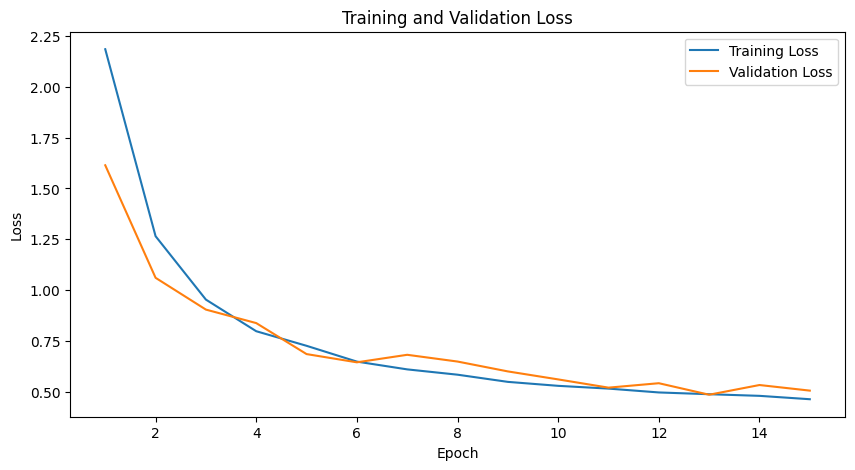

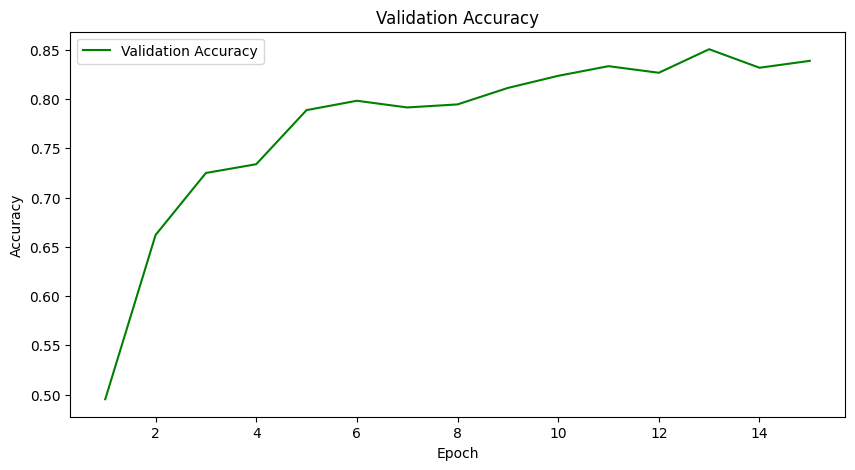

In [11]:
import matplotlib.pyplot as plt
# Extracted data from the console output
loss_values = [2.1843, 1.2651, 0.9534, 0.7980, 0.7263, 0.6486, 0.6104, 0.5843, 0.5490, 0.5295, 0.5159, 0.4970, 0.4883, 0.4803, 0.4637]
val_loss_values = [1.6138, 1.0606, 0.9043, 0.8380, 0.6856, 0.6451, 0.6821, 0.6489, 0.6004, 0.5611, 0.5206, 0.5424, 0.4858, 0.5335, 0.5060]
val_accuracy_values = [0.4953, 0.6620, 0.7249, 0.7338, 0.7887, 0.7982, 0.7914, 0.7945, 0.8112, 0.8235, 0.8333, 0.8266, 0.8505, 0.8317, 0.8387]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracy_values, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


#Testing the Unseen data

In [12]:
import os
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Assuming you have defined test_transform earlier
test_data = TestDataset(root_dir='/content/Project_dataset/Test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=60, shuffle=False)

# Iterate over the test_loader to access the images
for images in test_loader:
    # images is a batch of images, you can perform operations on them as needed
    print(images.shape)  # Print the shape of the batch of images
    # Your additional processing or testing code goes here


torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 60, 60])
torch.Size([60, 3, 6

# Testing the model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Testing the model
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)  # Move input tensors to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())  # Save the predicted labels for further analysis

# Printing predictions for the test set
print('Predictions for each image in the test set:')
print(predictions)
print(f'Number of images in the test set: {len(predictions)}')

# Save predictions to a file
with open('predictions.txt', 'w') as f:
    for pred in predictions:
        f.write(f'{pred}\n')

Predictions for each image in the test set:
[12, 40, 34, 35, 39, 1, 2, 28, 34, 4, 12, 14, 10, 22, 15, 5, 1, 25, 32, 40, 32, 2, 41, 2, 12, 19, 12, 18, 32, 8, 9, 4, 2, 16, 41, 16, 32, 42, 10, 25, 23, 1, 25, 39, 39, 5, 34, 25, 34, 4, 34, 29, 34, 1, 15, 34, 10, 32, 34, 18, 34, 5, 5, 4, 34, 5, 9, 40, 35, 5, 38, 29, 12, 42, 38, 42, 36, 18, 1, 10, 29, 40, 25, 38, 40, 26, 29, 29, 40, 1, 5, 18, 41, 28, 34, 12, 18, 12, 18, 38, 9, 2, 4, 2, 29, 12, 5, 34, 2, 5, 4, 25, 25, 13, 22, 38, 36, 40, 1, 3, 4, 25, 30, 40, 41, 34, 18, 9, 35, 18, 9, 26, 42, 40, 35, 29, 41, 2, 1, 4, 2, 1, 32, 9, 34, 2, 25, 25, 12, 0, 9, 6, 10, 23, 37, 8, 18, 5, 6, 22, 23, 6, 41, 2, 23, 30, 16, 6, 6, 9, 4, 4, 9, 35, 38, 41, 18, 34, 25, 35, 42, 32, 5, 41, 5, 35, 36, 40, 37, 9, 1, 2, 38, 20, 23, 10, 32, 8, 40, 2, 6, 35, 41, 0, 2, 6, 2, 2, 20, 40, 18, 2, 18, 35, 23, 34, 30, 23, 1, 32, 38, 4, 42, 24, 0, 41, 39, 20, 4, 10, 38, 29, 11, 38, 12, 35, 42, 5, 42, 42, 2, 9, 23, 41, 23, 2, 2, 14, 5, 42, 36, 41, 32, 34, 16, 32, 4, 1, 34, 38,

In [20]:
class_names = train_loader.dataset.dataset.classes
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Validation Loss: 0.4987, Validation Accuracy: 0.8397
Accuracy: 0.8397, Precision: 0.8564, Recall: 0.8397, F1-score: 0.8414
Confusion matrix, without normalization
Normalized confusion matrix


<Figure size 1500x1500 with 0 Axes>

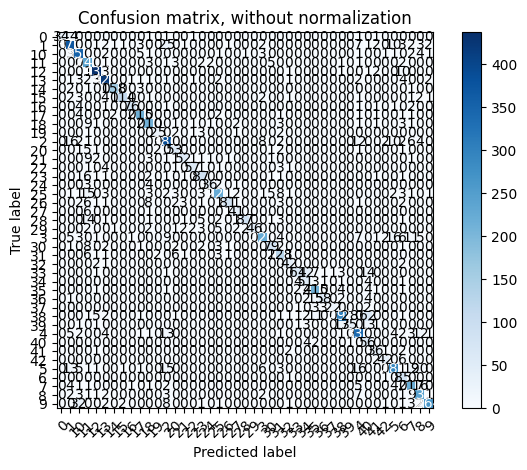

<Figure size 1800x1800 with 0 Axes>

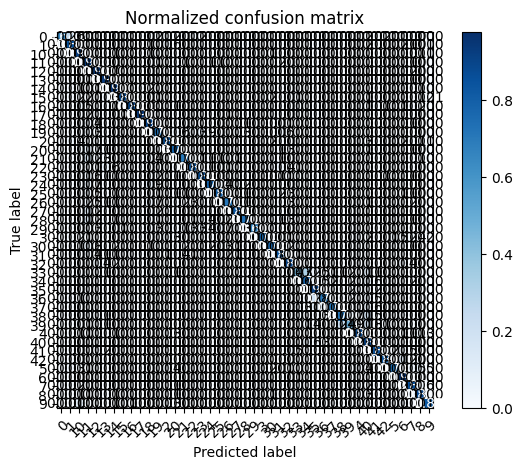

In [34]:
# Step 15: Evaluate the model on the validation dataset
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0
val_predictions = []
val_targets = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)  # Move input tensors to the same device as the model
        labels = labels.to(device)  # Move labels to the same device as the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

val_loss /= len(val_data)
val_accuracy = val_correct / val_total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Step 16: Calculate relevant metrics (accuracy, precision, recall, and F1-score)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(val_targets, val_predictions)
precision = precision_score(val_targets, val_predictions, average='weighted')
recall = recall_score(val_targets, val_predictions, average='weighted')
f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Step 17: Visualize the model's predictions and misclassifications
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Get the classes from the original dataset
val_classes = train_data.dataset.classes

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(val_targets, val_predictions, classes=val_classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(18, 18))
plot_confusion_matrix(val_targets, val_predictions, classes=val_classes, normalize=True, title='Normalized confusion matrix')

plt.show()


#Hyperparameter Tuning

In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
try:
    model = model.to(device)
except RuntimeError as e:
    if 'CUDA error' in str(e):
        print("CUDA error occurred. Falling back to CPU.")
        device = torch.device("cpu")
        model = model.to(device)
    else:
        raise e  # Re-raise the exception if it's not a CUDA error

print("Model moved to device:", device)

# Assuming 'train_data', 'train_loader', and 'valid_loader' are defined elsewhere

# Get class names dynamically from the original dataset
class_names = train_data.classes

# Defining hyperparameter grid
learning_rates = [0.001]
batch_sizes = [16, 32]

# Creating a list of hyperparameter combinations
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes))

# Dictionary to store results
results = {}

# Iterate over hyperparameter combinations
for lr, batch_size in hyperparameter_combinations:
    print(f"Training with learning rate: {lr}, batch size: {batch_size}")

    # Defining model, optimizer, and criterion with current hyperparameters
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Training the model
    model = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10)

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy}")

    # Store results
    results[(lr, batch_size)] = accuracy

# Find the best hyperparameters
best_hyperparams = max(results, key=results.get)
best_accuracy = results[best_hyperparams]

print(f"Best Hyperparameters: Learning Rate = {best_hyperparams[0]}, Batch Size = {best_hyperparams[1]}")
print(f"Validation Accuracy with Best Hyperparameters: {best_accuracy}")


Model moved to device: cuda


AttributeError: 'Subset' object has no attribute 'classes'